# Preamble

ATTENTION: Use a different kernel than the main analysis.ipynb file!!!

In [ ]:
%pip install plotly
%pip install seaborn
%pip install pandas
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 77.6 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
%run ./spark-instance-gustavo.ipynb

SparkConf created
Started SparkSession
Spark version 3.5.0


In [94]:
clean_spark()

In [2]:
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import pyspark.sql.types as pst
import pyspark.sql.functions as psf
import pyspark.pandas as ps
from pyspark.sql.window import Window

/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
ps.set_option('compute.ops_on_diff_frames', True)
pd.options.plotting.backend = 'matplotlib'

plt.rcParams["font.family"] = 'Nimbus Roman'   #"Times"
sns.set_theme(font='Nimbus Roman')
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})  # "whitegrid"

# Definitions

In [ ]:
LDAP_SERVER_NAME_FMT = "../dataset/processing/ldap-sequel/{timestamp}_{port}_ldap_root_dse_fp.csv"
HOSTS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tcp/result=hosts/year={year}/month={month:02d}/day={day:02d}"

tls_version_str_dict = {
    int("0x0301", 16): "TLSv1.0",
    int("0x0302", 16): "TLSv1.1",
    int("0x0303", 16): "TLSv1.2",
    int("0x0304", 16): "TLSv1.3",
    int("0x0300", 16): "SSLv3"
}

SNAPSHOTS = [
    {
        636: datetime(2024, 7, 9),
        389: datetime(2024, 7, 10),
        3269: datetime(2024, 7, 11),
        3268: datetime(2024, 7, 12),
    },
    {
        636: datetime(2024, 9, 10),
        389: datetime(2024, 9, 11),
        3269: datetime(2024, 9, 12),
        3268: datetime(2024, 9, 13),
    },
    {
        636: datetime(2024, 10, 29),
        389: datetime(2024, 10, 30),
        3269: datetime(2024, 10, 31),
        3268: datetime(2024, 11, 1),
    }
]

def load_hosts_data(port, ts):
    hosts_base_path = HOSTS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    return spark.read.option("header", "true"
                        ).option("lineSep", "\n"
                        ).option("quote", "\""
                        ).option("escape", "\""
                        ).option("inferSchema", "true"
                        ).csv(f"../dataset/{hosts_base_path}")


def load_ldap_server_name(port, d):
    ts = d.strftime("%Y%m%d")
    filename = LDAP_SERVER_NAME_FMT.format(timestamp=ts, port=port)
    return spark.read.option("header", "true"
                    ).option("inferSchema", "true"
                    ).csv(filename)


def tls_version_string_to_number(version_string: str):
    for k, v in tls_version_str_dict.items():
        if v == version_string:
            return k
    return None


def convert_win2016_2022(df):
    tlsv3 = tls_version_string_to_number("TLSv1.3")
    # no join! simple 'if' condition to avoid reduce the data set (to servers that respond to rootdse AND have TLS)
    return df.withColumn("server_name", psf.when(
        (psf.lower(psf.col("server_name")).contains("windows server 2016")) & (psf.col("protocol") == tlsv3),
        "Microsoft Active Directory Controller on Windows Server 2022"
        ).otherwise(psf.col("server_name"))
    )

def union_by_name(dfs):
    if len(dfs) == 1:
        return dfs[0]
    return dfs[0].unionByName(union_by_name(dfs[1:]))

# Extract data

In [ ]:
pdf = pd.DataFrame()
for snapshot in SNAPSHOTS:
    dfs = []
    last_ts = None
    for port, ts in snapshot.items():
        hosts_df = load_hosts_data(port, ts).drop("server_name")
        ldap_server_name_df = load_ldap_server_name(port, ts)

        ldap_fp_df = ldap_server_name_df.join(
            hosts_df,
            on=["id", "ip", "port"],
            how="left"  # keep all ldap_fp_df rows
        ).select("ip", "port", "server_name", "version", "protocol")

        ldap_fp_df = convert_win2016_2022(ldap_fp_df)
        ldap_fp_df = ldap_fp_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))
        dfs.append(ldap_fp_df)
        last_ts = ts
    df = union_by_name(dfs)
    pdf = pd.concat([
        pdf,
        df.dropDuplicates(["ip"]).groupBy("server_name").count().sort("count", ascending=False
        ).withColumn(
            "percent", psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
        ).withColumn(
            "date", psf.lit(last_ts).cast(pst.TimestampType())
        ).toPandas()
        ])

# Prepare data

Rename columns

In [ ]:
mod_server_name = {}
for server_name in pdf["server_name"].to_list():
    if server_name is None or isinstance(server_name, float):
        continue
    mod_server_name[server_name] = server_name.replace("Microsoft", "MS").replace("Active Directory Controller", "ADC").replace("Lightweight Directory Server", "LDS").replace("Windows Server 2016", "Windows Server 2016/2019").replace("Windows", "Win.").replace("Fedora Project ", "").replace("Platform Services Controller", "PSC")

copy_pdf = pdf.copy()

copy_pdf["server_name"] = copy_pdf["server_name"].map(mod_server_name)
copy_pdf["server_name"] = copy_pdf["server_name"].fillna("Unknown")

In [7]:
shorter_pdf = pd.DataFrame()
for d in copy_pdf["date"].unique():
    filtered_pdf = copy_pdf[copy_pdf["date"] == d]
    tail_copy_pdf = filtered_pdf[10:]
    tail_copy_pdf.loc[-1] = ["Other types",
                             tail_copy_pdf["count"].sum(),
                             tail_copy_pdf["percent"].sum(),
                             d]  # adding a row
    tail_copy_pdf.index = tail_copy_pdf.index + 1  # shifting index
    tail_copy_pdf.sort_index(inplace=True)

    _shorter_pdf = filtered_pdf[:10]
    _shorter_pdf.loc[-1] = tail_copy_pdf.loc[0]
    shorter_pdf = pd.concat([shorter_pdf, _shorter_pdf])

/tmp/ipykernel_637274/1076400435.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail_copy_pdf.loc[-1] = ["Other types",
/tmp/ipykernel_637274/1076400435.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail_copy_pdf.sort_index(inplace=True)
/tmp/ipykernel_637274/1076400435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _shorter_pdf.loc[-1] = tail_copy_pdf.loc[0]
/tmp/ipykernel_637274/1076400435.py:5: SettingWithCopyWarni

In [ ]:
shorter_pdf['date'] = shorter_pdf['date'].dt.strftime('%Y-%m')
server_names = shorter_pdf["server_name"].unique()

# Plot data

Stack plot

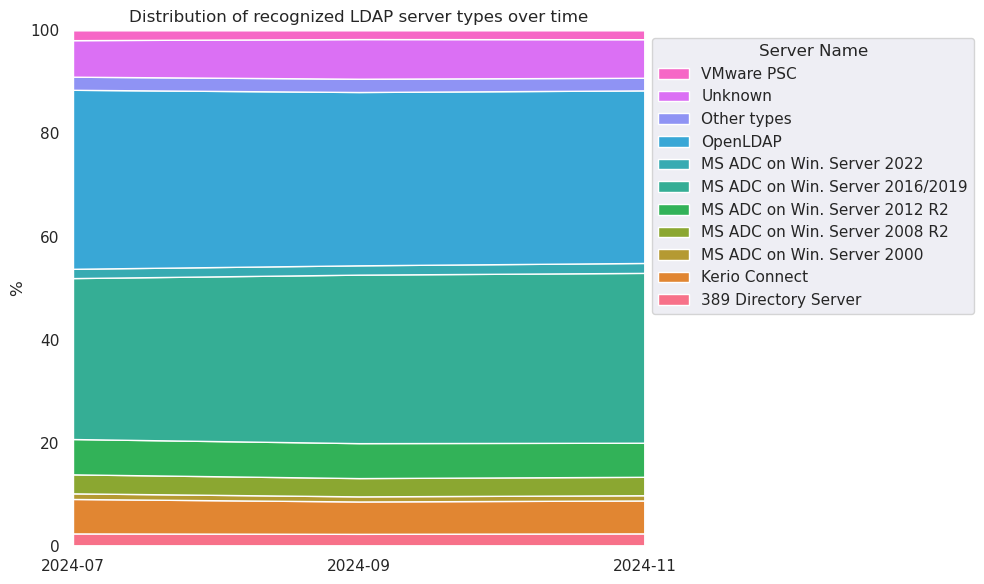

In [56]:
pdf_pivot = shorter_pdf.pivot(index='date', columns='server_name', values='percent')

# Sort by date to ensure proper stacking
pdf_pivot = pdf_pivot.sort_index()

sns.set_palette("husl", len(server_names))

plt.figure(figsize=(10, 6))

# Group by 'server name' and plot each server's data
#for server_name in server_names:
#    group = copy_pdf[copy_pdf['server_name'] == server_name]
#    plt.plot(group["date"], group["percent"], label=server_name, marker='^', linestyle='-')

stack = plt.stackplot(pdf_pivot.index, pdf_pivot.T, labels=list(pdf_pivot.columns))

# Add labels and title
plt.ylabel('%')
plt.title('Distribution of recognized LDAP server types over time')
anchor = (1, 1)
plt.legend(handles=stack[::-1], 
           labels=list(pdf_pivot.columns[::-1]),
           title='Server Name',
           loc='upper left',
           bbox_to_anchor=anchor)

#plt.xticks(pdf_pivot.index, pdf_pivot.index.strftime('%Y-%m'))
plt.grid(False)

plt.tight_layout()
plt.xlim(pdf_pivot.index[0], pdf_pivot.index[-1])
plt.ylim(0, 100)

# Show the plot
plt.savefig("output/ldap_server_type_longitudinal.pdf", bbox_inches='tight')
plt.show()

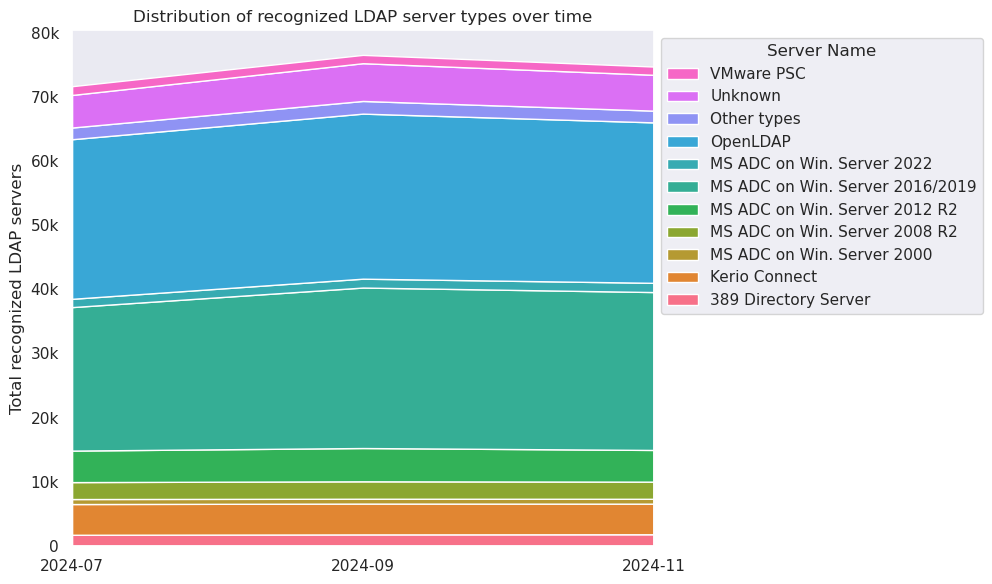

In [71]:
pdf_pivot = shorter_pdf.pivot(index='date', columns='server_name', values='count')

# Sort by date to ensure proper stacking
pdf_pivot = pdf_pivot.sort_index()
pdf_pivot = pdf_pivot.div(1000)
sns.set_palette("husl", len(server_names))

plt.figure(figsize=(10, 6))

# Group by 'server name' and plot each server's data
#for server_name in server_names:
#    group = copy_pdf[copy_pdf['server_name'] == server_name]
#    plt.plot(group["date"], group["percent"], label=server_name, marker='^', linestyle='-')

stack = plt.stackplot(pdf_pivot.index, pdf_pivot.T, labels=list(pdf_pivot.columns))

# Add labels and title
plt.ylabel('Total recognized LDAP servers')
plt.title('Distribution of recognized LDAP server types over time')
anchor = (1, 1)
plt.legend(handles=stack[::-1], 
           labels=list(pdf_pivot.columns[::-1]),
           title='Server Name',
           loc='upper left',
           bbox_to_anchor=anchor)

#plt.xticks(pdf_pivot.index, pdf_pivot.index.strftime('%Y-%m'))

plt.grid(False)

plt.tight_layout()
plt.xlim(pdf_pivot.index[0], pdf_pivot.index[-1])

plt.yticks(range(0, 90, 10), [f"{i}k" if i != 0 else "0" for i in range(0, 90, 10)])

# Show the plot
plt.savefig("output/ldap_server_type_longitudinal_cnt.pdf", bbox_inches='tight')
plt.show()

Sankey diagram

In [ ]:
# Create a list of unique servers and dates
servers = shorter_pdf['server_name'].unique()
dates = shorter_pdf['date'].unique()

# Generate node labels in the format "server - date"
node_labels = [f"{server} - {date}" for date in dates for server in servers]

# Map node labels to indices
node_indices = {label: i for i, label in enumerate(node_labels)}

# Define source, target, and values for the Sankey links
source = []
target = []
values = []

# Iterate over dates to create flows
for i in range(len(dates) - 1):
    date_from = dates[i]
    date_to = dates[i + 1]
    
    # Filter data for each pair of dates
    data_from = shorter_pdf[shorter_pdf['date'] == date_from]
    data_to = shorter_pdf[shorter_pdf['date'] == date_to]
    
    for server in servers:
        # Get percentage values for the server on both dates
        percentage_from = data_from[data_from['server_name'] == server]['percent'].values
        percentage_to = data_to[data_to['server_name'] == server]['percent'].values
        
        if percentage_from.size > 0 and percentage_to.size > 0:
            # Add source, target, and value for each flow
            source.append(node_indices[f"{server} - {date_from}"])
            target.append(node_indices[f"{server} - {date_to}"])
            values.append(percentage_from[0])  # Or use percentage_to[0] if you want the flow to be the latter

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
)])

fig.update_layout(title_text="Sankey Diagram of Server Percentages over Time", font_size=10)
fig.show()

In [27]:
# Assume `pdf` is your DataFrame
# Format date to "YYYY-MM" for annotation
#shorter_pdf['date'] = shorter_pdf['date'].dt.strftime('%Y-%m')

# Create a list of unique servers and dates
servers = shorter_pdf['server_name'].unique()
dates = shorter_pdf['date'].unique()

# Generate simplified node labels with only server names
node_labels = [f"{server}" for date in dates for server in servers]

# Map node labels to indices
node_indices = {f"{server} - {date}": i for i, (date, server) in enumerate([(d, s) for d in dates for s in servers])}

# Define source, target, and values for the Sankey links
source = []
target = []
values = []

# Iterate over dates to create flows
for i in range(len(dates) - 1):
    date_from = dates[i]
    date_to = dates[i + 1]
    
    # Filter data for each pair of dates
    data_from = shorter_pdf[shorter_pdf['date'] == date_from]
    data_to = shorter_pdf[shorter_pdf['date'] == date_to]
    
    for server in servers:
        # Get percentage values for the server on both dates
        percentage_from = data_from[data_from['server_name'] == server]['percent'].values
        percentage_to = data_to[data_to['server_name'] == server]['percent'].values
        
        if percentage_from.size > 0 and percentage_to.size > 0:
            # Add source, target, and value for each flow
            source.append(node_indices[f"{server} - {date_from}"])
            target.append(node_indices[f"{server} - {date_to}"])
            values.append(percentage_from[0])  # Or use percentage_to[0] if you want the flow to be the latter

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
)])

# Add annotation for the dates at the bottom
fig.update_layout(
    title_text="Sankey Diagram of Server Percentages over Time",
    font_size=10,
    annotations=[dict(
        text=" - ".join(dates),
        x=0.5, y=-0.1, xref="paper", yref="paper",
        showarrow=False,
        font=dict(size=12)
    )]
)

fig.show()


In [73]:
# Assume `pdf` is your DataFrame
# Format date to "YYYY-MM" for annotation
#shorter_pdf['date'] = shorter_pdf['date'].dt.strftime('%Y-%m')

# Create a list of unique servers and dates
servers = shorter_pdf['server_name'].unique()
dates = shorter_pdf['date'].unique()

# Generate simplified node labels with only server names
node_labels = [f"{server}" for date in dates for server in servers]

# Map node labels to indices
node_indices = {f"{server} - {date}": i for i, (date, server) in enumerate([(d, s) for d in dates for s in servers])}

# Define source, target, and values for the Sankey links
source = []
target = []
values = []

# Iterate over dates to create flows
for i in range(len(dates) - 1):
    date_from = dates[i]
    date_to = dates[i + 1]
    
    # Filter data for each pair of dates
    data_from = shorter_pdf[shorter_pdf['date'] == date_from]
    data_to = shorter_pdf[shorter_pdf['date'] == date_to]
    
    for server in servers:
        # Get percentage values for the server on both dates
        percentage_from = data_from[data_from['server_name'] == server]['count'].values
        percentage_to = data_to[data_to['server_name'] == server]['count'].values
        
        if percentage_from.size > 0 and percentage_to.size > 0:
            # Add source, target, and value for each flow
            source.append(node_indices[f"{server} - {date_from}"])
            target.append(node_indices[f"{server} - {date_to}"])
            values.append(percentage_from[0])  # Or use percentage_to[0] if you want the flow to be the latter

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
)])

# Add annotation for the dates at the bottom
fig.update_layout(
    title_text="Sankey Diagram of Server Count over Time",
    font_size=10,
    annotations=[dict(
        text=" - ".join(dates),
        x=0.5, y=-0.1, xref="paper", yref="paper",
        showarrow=False,
        font=dict(size=12)
    )]
)

fig.show()
